In [2]:
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np
import os
from pathlib import Path
import json
import collections
from src.visualize import filter_path_1, filter_path_2, get_scores, get_scores_json, plot_scores, calculate_average_ranking, calculate_average_score

In [69]:
## 160M models
# inc_model = "./models/pythia/experiment_1/huggingface/flan_v1/ds_c4_small/EleutherAI/pythia-160M-deduped_ckpt_False/checkpoint-70000/inference/lm-harness/hendrycks*/results.json"
# pythia_model = "/share/edc/home/antonis/LLM-Incidental-Supervision/pythia/evals/pythia-v0/pythia-160m-deduped/zero-shot/pythia-160m-deduped-0shot-global_step16500_eval_results_12-30-2022-22-38-08.json"

## 1.4B models
inc_model = "./models/pythia/experiment_1/huggingface/flan_v1/ds_c4_small/EleutherAI/pythia-1.4B-deduped_ckpt_False/checkpoint-70000/inference/lm-harness/hendrycks*/results.json"
inc_commonsense_model = "./models/pythia/experiment_1/huggingface/flan_v1/c4_mixed_Commonsense/EleutherAI/pythia-1.4B-deduped_ckpt_False/checkpoint-70000/inference/lm-harness/hendrycks*/results.json"
pythia_model_ckpt = "/share/edc/home/antonis/LLM-Incidental-Supervision/pythia/evals/pythia-v0/pythia-1.4b-deduped/zero-shot/pythia-1.4b-deduped-0shot-global_step16500_eval_results_12-30-2022-03-54-27.json"
pythia_model_full = "/share/edc/home/antonis/LLM-Incidental-Supervision/pythia/evals/pythia-v0/pythia-1.4b-deduped/zero-shot/pythia-1.4b-deduped-0shot-global_step71500_eval_results_12-30-2022-04-43-36.json"
pythia_full_7B = "/share/edc/home/antonis/LLM-Incidental-Supervision/pythia/evals/pythia-v0/pythia-6.9b-deduped/zero-shot/pythia-6.9b-deduped-0shot-global_step143000_eval_results_12-20-2022-20-15-20.json"
pythia_full_12B = "/share/edc/home/antonis/LLM-Incidental-Supervision/pythia/evals/pythia-v0/pythia-12b-deduped/zero-shot/pythia-12b-deduped-0shot-global_step143000_eval_results_12-16-2022-19-23-03.json"
pythia_v1_full = "/share/edc/home/antonis/LLM-Incidental-Supervision/pythia/evals/pythia-v1/pythia-1.4b-deduped/zero-shot/1.4b-deduped_step143000.json"

with open(inc_model) as f:
    inc_results = json.load(f)

with open(inc_commonsense_model) as f:
    inc_commonsense_results = json.load(f)

with open(pythia_model_ckpt) as f:
    pythia_results_ckpt = json.load(f)

with open(pythia_model_full) as f:
    pythia_results_full = json.load(f)

with open(pythia_full_7B) as f:
    pythia_results_7B = json.load(f)

with open(pythia_full_12B) as f:
    pythia_results_12B = json.load(f)

with open(pythia_v1_full) as f:
    pythia_v1_results = json.load(f)

{'c4_small_1.4B': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'c4_commonsense_1.4B': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), 'pythia_ckpt_1.4B': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'pythia_full_1.4B': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0), 'pythia_full_7B': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'pythia_full_12B': (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0), 'pythia_v1_full_1.4B': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)}


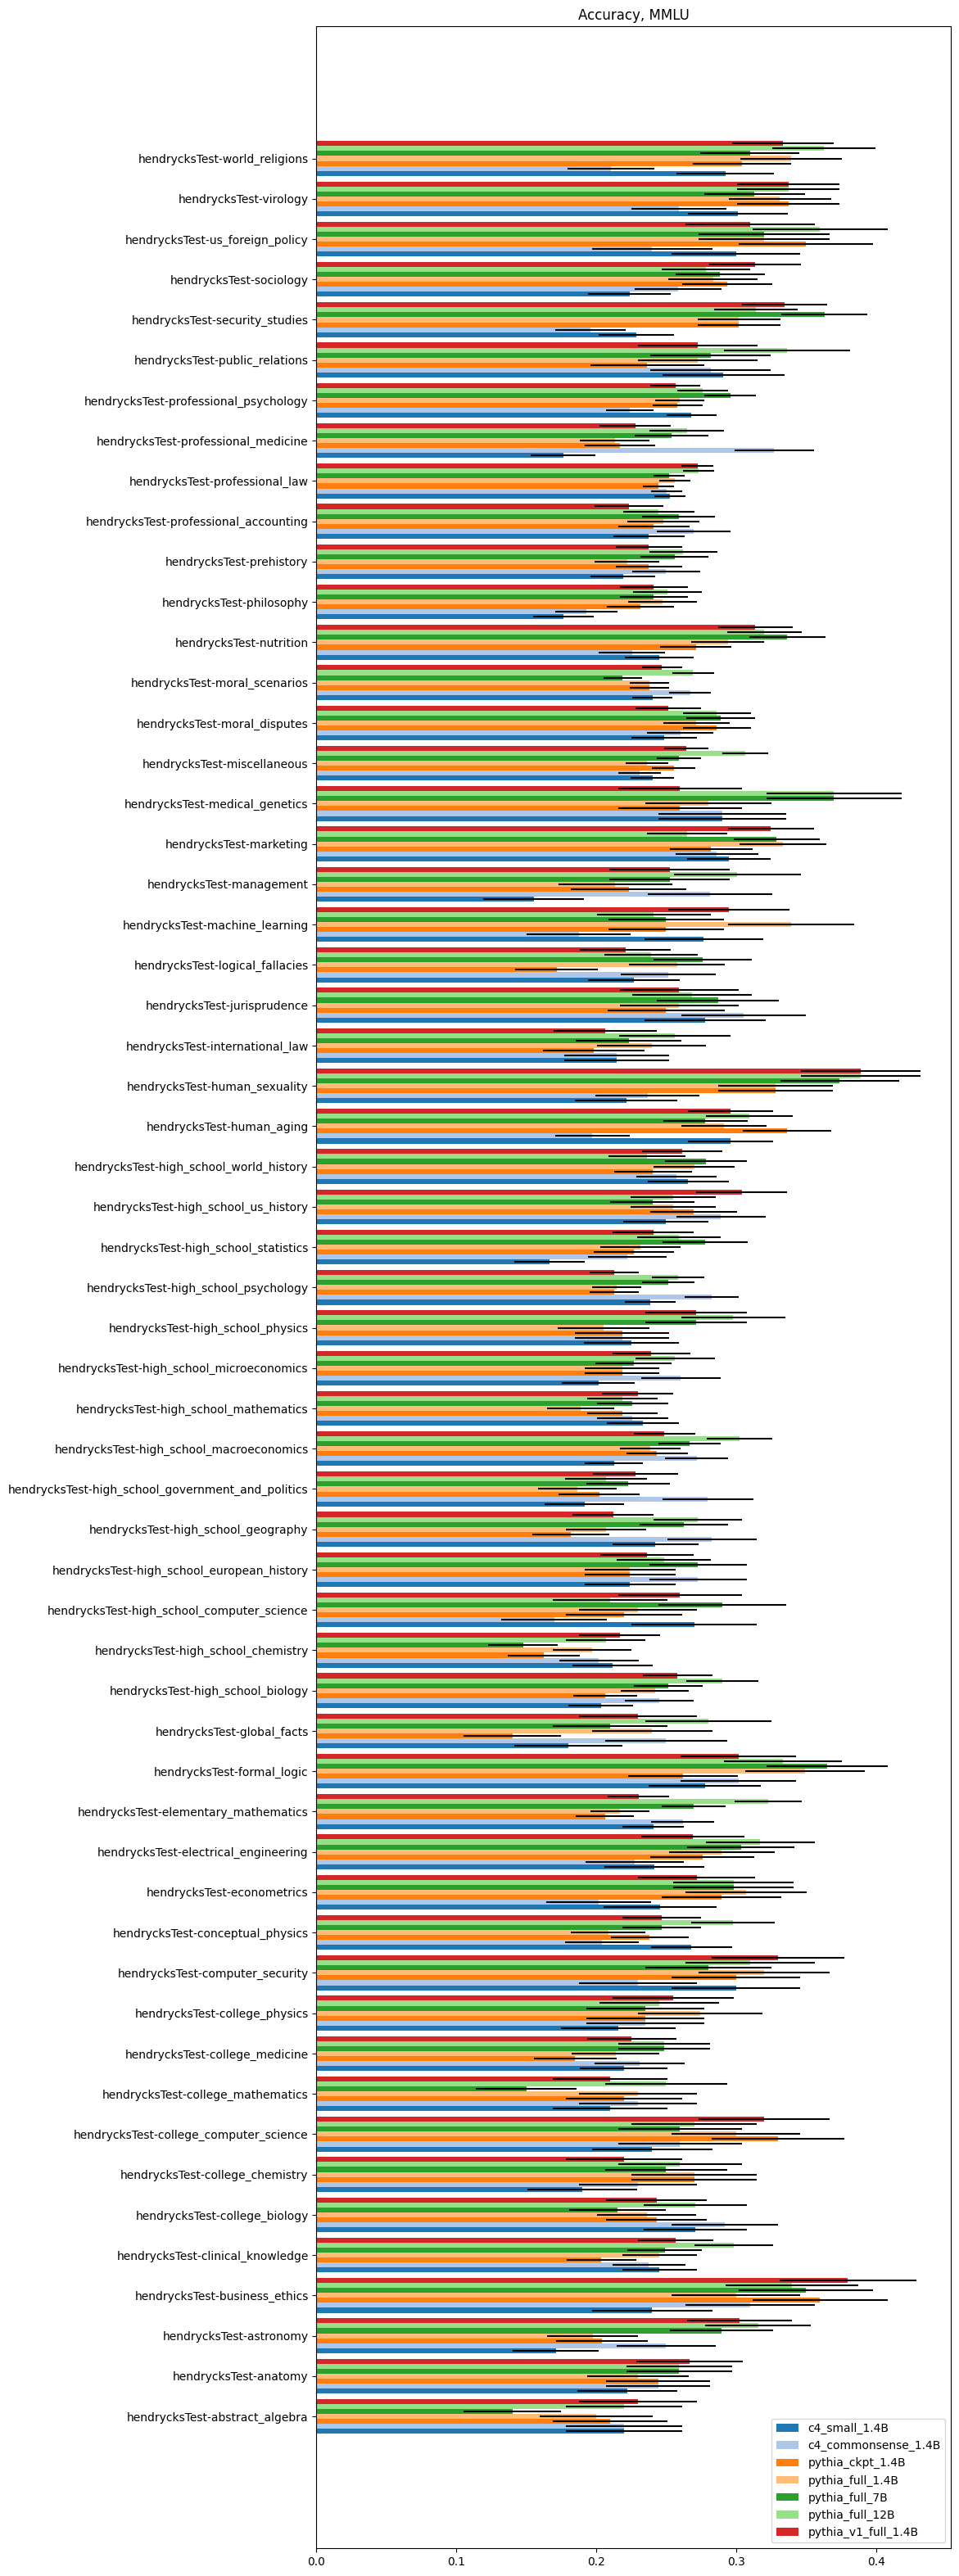

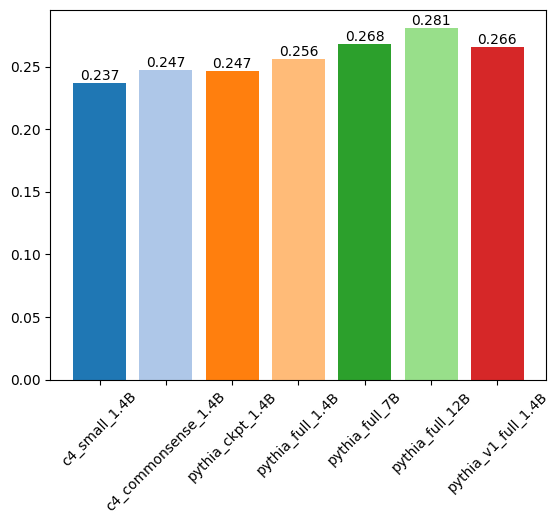

In [70]:
save_path = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/results"


def plot_model_results(model_results, save_path):
    color_palette = plt.get_cmap('tab20')
    model_colors = {model: color_palette(i) for i, model in enumerate(model_results.keys())}
    print(model_colors)
    bar_width = 0.9  # Specify bar width
    space_between_groups = 0.3  # Specify space between groups

    # Create a single figure and axes before the loop
    fig, ax = plt.subplots(figsize=(10, 40))

    # Get the list of all datasets
    datasets = set(model_results[next(iter(model_results))]['results'].keys())
    for results in model_results.values():
        datasets = datasets.intersection(set(results['results'].keys()))
    datasets = sorted(list(datasets))

    average_results = {model: [] for model in model_results.keys()}

    for i, dataset in enumerate(datasets):
        for j, model in enumerate(model_results.keys()):
            results = model_results[model]
            if dataset in results['results']:
                result = results['results'][dataset]
                ax.barh(i*(len(model_results)+space_between_groups) + j*bar_width, result['acc'], bar_width, xerr=result['acc_stderr'], color=model_colors[model], label=f'{model}' if i == 0 else "")
                average_results[model].append(result['acc'])

    # Set the yticks to be the dataset names
    ax.set_title('Accuracy, MMLU')
    ax.set_yticks([i*(len(model_results)+space_between_groups) + bar_width*(len(model_results)-1)/2 for i in range(len(datasets))])
    ax.set_yticklabels(datasets)

    # Add a legend
    ax.legend()

    plt.savefig(os.path.join(save_path, 'model_results_MMLU.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate the average accuracy for each model
    for model in average_results.keys():
        average_results[model] = sum(average_results[model]) / len(average_results[model])

    # Plot the average results
    fig, ax = plt.subplots()
    bars = ax.bar(np.arange(len(average_results.keys())), average_results.values(), color=[model_colors[model] for model in average_results.keys()])
    ax.set_xticks(np.arange(len(average_results.keys())))
    ax.set_xticklabels(average_results.keys())
    plt.xticks(rotation=45)  # Rotate x-ticks by 45 degrees

    # Add the text of the accuracy for the bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, 
                height, 
                f'{height:.3f}', 
                ha='center', 
                va='bottom')

    plt.savefig(os.path.join(save_path, 'average_results_MMLU.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Usage:
model_results = {
    'c4_small_1.4B': inc_results,
    'c4_commonsense_1.4B': inc_commonsense_results,
    'pythia_ckpt_1.4B': pythia_results_ckpt,
    'pythia_full_1.4B': pythia_results_full,
    'pythia_full_7B': pythia_results_7B,
    'pythia_full_12B': pythia_results_12B,
    'pythia_v1_full_1.4B': pythia_v1_results
    # Add more models as needed
}
plot_model_results(model_results, save_path)

In [51]:
# average_results = {'inc': [], 'pythia': []}
# bar_width = 0.35
# opacity = 0.8
# save_path = "./incidental-supervision/results/pythia_vs_inc/"

# # Create a single figure and axes before the loop
# fig, ax = plt.subplots(figsize=(10, 50))

# # Use enumerate to get both the index and dataset from inc_results['results'].keys()
# for i, dataset in enumerate(inc_results['results'].keys()):
#     if dataset in pythia_results['results'].keys():
#         inc_result = inc_results['results'][dataset]
#         pythia_result = pythia_results['results'][dataset]

#         # Use i instead of a fixed index
#         ax.barh(i, inc_result['acc'], bar_width, xerr=inc_result['acc_stderr'], color='b', label='inc' if i == 0 else "")
#         ax.barh(i + bar_width, pythia_result['acc'], bar_width, xerr=pythia_result['acc_stderr'], color='r', label='pythia' if i == 0 else "")

#         average_results['inc'].append(inc_result['acc'])
#         average_results['pythia'].append(pythia_result['acc'])

# # Set the yticks to be the dataset names
# ax.set_title('Accuracy, MMLU')
# ax.set_yticks(np.arange(len(inc_results['results'].keys())))
# ax.set_yticklabels(inc_results['results'].keys())

# # Add a legend
# ax.legend()

# plt.savefig(os.path.join(save_path, 'pythia_vs_inc_MMLU.png'), dpi=300, bbox_inches='tight')

# average_results['inc'] = np.mean(average_results['inc'])
# average_results['pythia'] = np.mean(average_results['pythia'])

# # Plot the average results
# fig, ax = plt.subplots()
# bars = ax.barh(np.arange(len(average_results.keys())), average_results.values(), color='b')
# ax.set_yticks(np.arange(len(average_results.keys())))
# ax.set_yticklabels(average_results.keys())

# # Add the text of the accuracy for the two bars
# for bar in bars:
#     width = bar.get_width()
#     ax.text(width, 
#             bar.get_y() + bar.get_height()/2, 
#             f'{width:.2f}', 
#             ha='left', 
#             va='center')

        
# plt.savefig(os.path.join(save_path, 'pythia_vs_inc_MMLU_average.png'), dpi=300, bbox_inches='tight')
# plt.show()